In [13]:
import pandas as pd
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import numpy as np
import torch
import torch.nn as nn

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [4]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
counts_df = counts_pd
labels_df = labels_pd

counts_df = counts_df.loc[labels_df.index]
combined_df = counts_df.copy()
combined_df['cell_type'] = labels_df['bulk_labels']

shuffled_df = combined_df.sample(frac=1, random_state=42)

shuffled_counts = shuffled_df.drop(columns=['cell_type','Unnamed: 0'])
#shuffled_counts = shuffled_df.drop(columns='Unnamed: 0')
shuffled_labels = shuffled_df['cell_type']

X_train, X_test, y_train, y_test = train_test_split(
    shuffled_counts,
    shuffled_labels,
    test_size=0.2,
    random_state=42,
    stratify=shuffled_labels  
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print(X_test)
print(X_test.columns)

Train shape: (560, 765) (560,)
Test shape: (140, 765) (140,)
      HES4  TNFRSF4  SSU72  PARK7   RBP7    SRM  MAD2L2  AGTRAP  TNFRSF1B  \
604 -0.326   -0.191  1.539  0.069 -0.174  0.541  -0.451  -0.486    -0.459   
48  -0.326   -0.191 -0.728  1.266 -0.174 -0.531  -0.451  -0.486    -0.459   
258 -0.326   -0.191  2.846  0.134 -0.174  0.596  -0.451  -0.486    -0.459   
683 -0.326   -0.191  0.548  0.228 -0.174 -0.531  -0.451  -0.486    -0.459   
69  -0.326   -0.191  0.139 -0.230 -0.174 -0.531  -0.451  -0.486    -0.459   
..     ...      ...    ...    ...    ...    ...     ...     ...       ...   
81  -0.326   -0.191 -0.728 -0.064 -0.174  0.429  -0.451  -0.486    -0.459   
191 -0.326    2.234 -0.728 -0.579 -0.174  0.518  -0.451  -0.486    -0.459   
190 -0.326   -0.191  0.745 -1.200 -0.174 -0.531   1.812  -0.486    -0.459   
263 -0.326   -0.191 -0.728 -0.509 -0.174 -0.531  -0.451  -0.486     0.899   
510 -0.326   -0.191  1.497  0.669 -0.174 -0.531  -0.451  -0.486    -0.459   

     EFHD2  ..

Create a fully connected neural network for your autoencoder. Your latent space can be of any size less than or equal to 64. Too large may result in a poor visualization, and too small may result in high loss. 32 is a good starting point.

Consider using more than 1 hidden layer, and a sparcity constraint (l1 regularization).

Have an encoder model which is a model of only the layers for the encoding.

In [10]:
import torch
import torch.nn as nn
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=64):  # Use 64 if you trained with that
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),  # MUST include dropout if used in training
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z
scaler = StandardScaler()


X_all_scaled = scaler.fit_transform(pd.concat([X_train, X_test]))

input_dim = X_all_scaled.shape[1]
model = Autoencoder(input_dim=input_dim, latent_dim=64)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load("autoencoder_model_ALL.pt"))
model.eval()
X_tensor = torch.tensor(X_all_scaled, dtype=torch.float32).to(device)

# Extract latent representations
with torch.no_grad():
    _, Z = model(X_tensor)

Z_np = Z.cpu().numpy()


In [ ]:

# from sklearn.preprocessing import StandardScaler


# X_train = X_train.apply(pd.to_numeric, errors='coerce')
# X_test = X_test.apply(pd.to_numeric, errors='coerce')

# #fill NaNs with 0 or mean
# X_train = X_train.fillna(0)
# X_test = X_test.fillna(0)


# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)


# input_dim = X_train.shape[1]
# model = Autoencoder(input_dim=input_dim, latent_dim=32).to(device)

# optimizer = optim.Adam(model.parameters(), lr=1e-3)
# mse_loss = nn.MSELoss()

# lambda_l1 = 1e-4

# n_epochs = 100
# batch_size = 128

# for epoch in range(n_epochs):
#     model.train()
#     permutation = torch.randperm(X_train_tensor.size(0))
#     total_loss = 0

#     for i in range(0, X_train_tensor.size(0), batch_size):
#         indices = permutation[i:i+batch_size]
#         batch_x = X_train_tensor[indices]

#         optimizer.zero_grad()
#         x_hat, z = model(batch_x)
#         loss = mse_loss(x_hat, batch_x) + lambda_l1 * torch.norm(z, p=1)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Train your autoencoding using MSE loss.

Finally, identify the parameters which don't overfit, and use the same model architecture and train on all of the data together.

With a latent space size of 32, aim for 0.9 MSE loss on your test set, 0.95 with regularization. You will not be graded strictly on a loss cutoff.

In [11]:
def train_autoencoder(model, X_train_tensor, X_test_tensor, 
                      n_epochs=100, batch_size=128, lr=1e-3, lambda_l1=1e-4):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    train_losses, test_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        permutation = torch.randperm(X_train_tensor.size(0))
        total_train_loss = 0

        for i in range(0, X_train_tensor.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_x = X_train_tensor[indices]

            optimizer.zero_grad()
            x_hat, z = model(batch_x)
            loss = mse_loss(x_hat, batch_x) + lambda_l1 * torch.norm(z, p=1)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            x_hat_test, _ = model(X_test_tensor)
            test_loss = mse_loss(x_hat_test, X_test_tensor).item()

        avg_train_loss = total_train_loss / (X_train_tensor.size(0) // batch_size)
        train_losses.append(avg_train_loss)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1:03d} | Train MSE: {avg_train_loss:.4f} | Test MSE: {test_loss:.4f}")

    return train_losses, test_losses


In [14]:
# X_all_tensor = torch.tensor(pd.concat([X_train, X_test]).values, dtype=torch.float32).to(device)

# final_model = Autoencoder(input_dim=X_all_tensor.shape[1], latent_dim=32)

# train_autoencoder(final_model, X_all_tensor, X_all_tensor, n_epochs=85, lambda_l1=5e-5)
# torch.save(final_model.state_dict(), "autoencoder_model.pt") 
# Final autoencoder training on full dataset (no validation needed)
# X_all_scaled = scaler.transform(pd.concat([X_train, X_test]))
X_train_scaled, X_test_scaled = train_test_split(X_all_scaled, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)


final_model = Autoencoder(input_dim=X_train_tensor.shape[1], latent_dim=64) #can we reload this model to other doc or need X_all?

train_autoencoder(final_model, X_train_tensor, X_test_tensor, n_epochs=60, lambda_l1=1e-6)
# torch.save(final_model.state_dict(), "autoencoder_model.pt")

Epoch 001 | Train MSE: 1.2464 | Test MSE: 1.0060
Epoch 002 | Train MSE: 1.2272 | Test MSE: 0.9790
Epoch 003 | Train MSE: 1.1825 | Test MSE: 0.9379
Epoch 004 | Train MSE: 1.1251 | Test MSE: 0.9120
Epoch 005 | Train MSE: 1.1128 | Test MSE: 0.8998
Epoch 006 | Train MSE: 1.0989 | Test MSE: 0.8919
Epoch 007 | Train MSE: 1.0756 | Test MSE: 0.8855
Epoch 008 | Train MSE: 1.0697 | Test MSE: 0.8776
Epoch 009 | Train MSE: 1.0550 | Test MSE: 0.8732
Epoch 010 | Train MSE: 1.0552 | Test MSE: 0.8696
Epoch 011 | Train MSE: 1.0407 | Test MSE: 0.8688
Epoch 012 | Train MSE: 1.0357 | Test MSE: 0.8664
Epoch 013 | Train MSE: 1.0323 | Test MSE: 0.8652
Epoch 014 | Train MSE: 1.0235 | Test MSE: 0.8642
Epoch 015 | Train MSE: 1.0198 | Test MSE: 0.8628
Epoch 016 | Train MSE: 1.0115 | Test MSE: 0.8627
Epoch 017 | Train MSE: 0.9971 | Test MSE: 0.8614
Epoch 018 | Train MSE: 0.9941 | Test MSE: 0.8615
Epoch 019 | Train MSE: 0.9924 | Test MSE: 0.8602
Epoch 020 | Train MSE: 0.9871 | Test MSE: 0.8589
Epoch 021 | Train MS

([1.2464448660612106,
  1.227236345410347,
  1.1824630498886108,
  1.1251007616519928,
  1.1128123849630356,
  1.0988772511482239,
  1.0755635052919388,
  1.0696951597929,
  1.0549970120191574,
  1.055195152759552,
  1.0407070070505142,
  1.0357382595539093,
  1.032273292541504,
  1.0234700590372086,
  1.0198270231485367,
  1.011507734656334,
  0.9971313923597336,
  0.9941415339708328,
  0.9924394935369492,
  0.9871375560760498,
  0.9776256233453751,
  0.9753132313489914,
  0.9621968418359756,
  0.9444409906864166,
  0.9350739866495132,
  0.9385322630405426,
  0.9224944412708282,
  0.907155305147171,
  0.9036868363618851,
  0.8997558206319809,
  0.8913977742195129,
  0.8793768733739853,
  0.8599735051393509,
  0.8545403778553009,
  0.8516597300767899,
  0.8430520296096802,
  0.8223551362752914,
  0.8200843632221222,
  0.8115348368883133,
  0.8036446273326874,
  0.7944090813398361,
  0.7848198115825653,
  0.7776670604944229,
  0.7714884430170059,
  0.7663985043764114,
  0.75445942580699

Use PCA and t-SNE on the dataset.

Then use PCA on the latent space representation of the dataset.

Plot all of these.

In [15]:
all_labels = pd.concat([y_train, y_test]).values


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as n

pca_raw = PCA(n_components=2).fit_transform(X_all_scaled)
tsne_raw = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_all_scaled)


In [16]:
#final_model.eval()
with torch.no_grad():
    latent_vectors = final_model.encoder(torch.tensor(X_all_scaled, dtype=torch.float32).to(device)).cpu().numpy()

# pca latent space
# pca_latent = PCA(n_components=2).fit_transform(latent_vectors)
scaler_latent = StandardScaler()
latent_scaled = scaler_latent.fit_transform(latent_vectors)

pca_latent = PCA(n_components=2).fit_transform(latent_vectors)

Compare the results of PCA, t-SNE, and your autoencoder as ways to visualize the data.

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Encode cell types
label_encoder = LabelEncoder()
label_ids = label_encoder.fit_transform(all_labels)
unique_labels = label_encoder.classes_

def plot_scatter(data_2d, label_ids, title, save_path=None,show_legend=True,):
    # Create a DataFrame for easier labeling
    df_plot = pd.DataFrame({
        'Component 1': data_2d[:, 0],
        'Component 2': data_2d[:, 1],
        'Cell Type': label_encoder.inverse_transform(label_ids)
    })

    # Plot with seaborn
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.scatterplot(
        data=df_plot,
        x='Component 1',
        y='Component 2',
        hue='Cell Type',
        palette='tab10',
        s=12,
        ax=ax,
        linewidth=0
    )

    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    if show_legend:
        ax.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.get_legend().remove()

    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


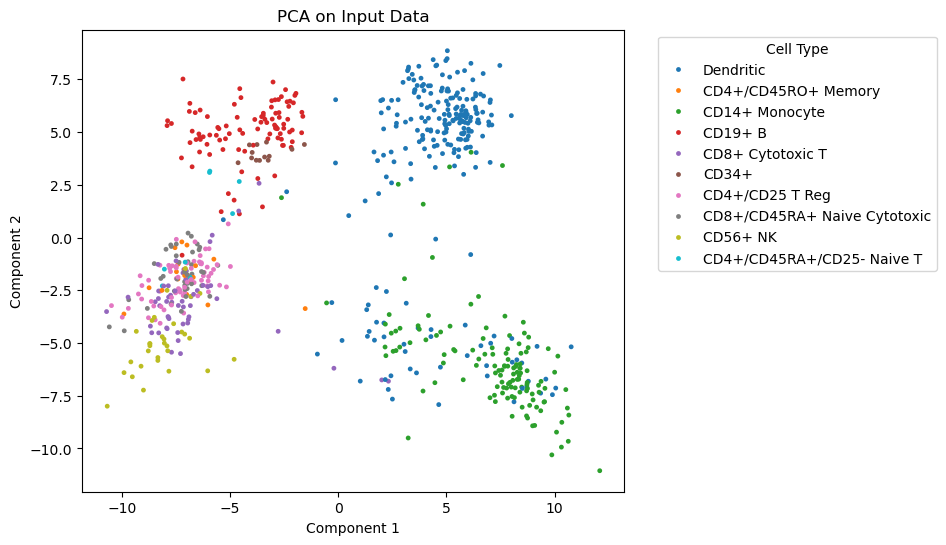

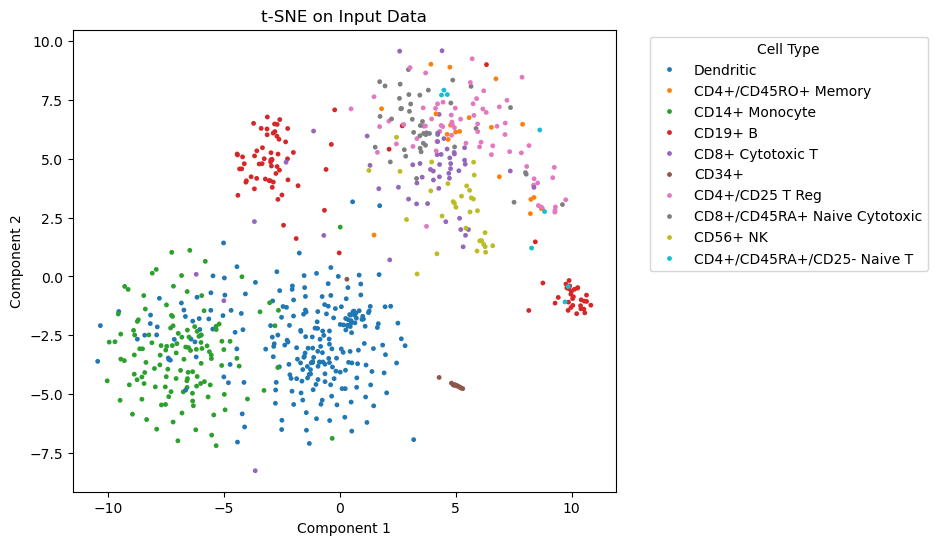

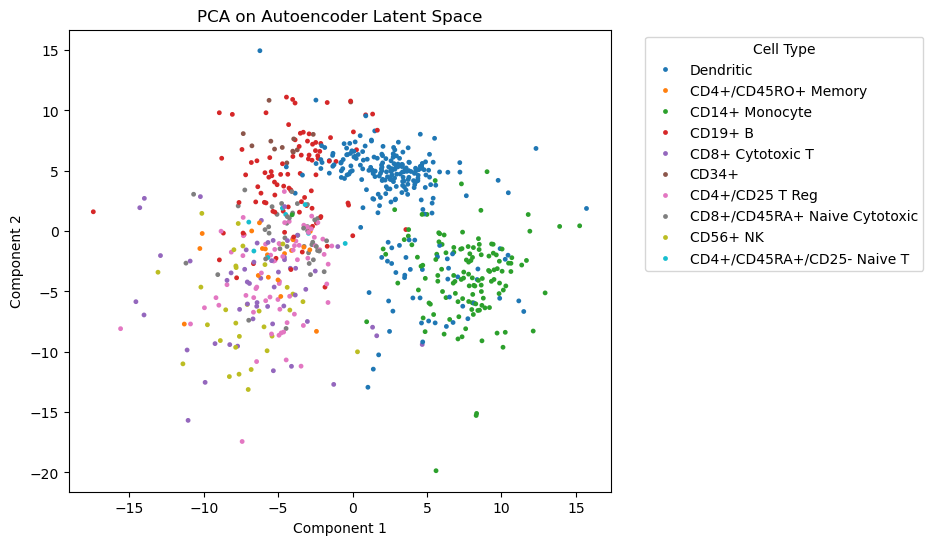

In [23]:
plot_scatter(pca_raw, label_ids, "PCA on Input Data", "pca_input_data.png")
plot_scatter(tsne_raw, label_ids, "t-SNE on Input Data","tsne_input_data.png")
plot_scatter(pca_latent, label_ids, "PCA on Autoencoder Latent Space","pca_latent_data.png")


In [94]:
X_all_tensor = torch.tensor(X_all_scaled, dtype=torch.float32).to(device)
final_model = Autoencoder(input_dim=X_all_tensor.shape[1], latent_dim=64) #can we reload this model to other doc or need X_all?

train_autoencoder(final_model, X_all_tensor, X_all_tensor, n_epochs=60, lambda_l1=1e-6)
torch.save(final_model.state_dict(), "autoencoder_model_ALL.pt")

Epoch 001 | Train MSE: 1.2319 | Test MSE: 1.0123
Epoch 002 | Train MSE: 1.1902 | Test MSE: 0.9686
Epoch 003 | Train MSE: 1.1509 | Test MSE: 0.9371
Epoch 004 | Train MSE: 1.1217 | Test MSE: 0.9072
Epoch 005 | Train MSE: 1.0970 | Test MSE: 0.8917
Epoch 006 | Train MSE: 1.0704 | Test MSE: 0.8771
Epoch 007 | Train MSE: 1.0550 | Test MSE: 0.8649
Epoch 008 | Train MSE: 1.0483 | Test MSE: 0.8589
Epoch 009 | Train MSE: 1.0390 | Test MSE: 0.8521
Epoch 010 | Train MSE: 1.0337 | Test MSE: 0.8460
Epoch 011 | Train MSE: 1.0244 | Test MSE: 0.8410
Epoch 012 | Train MSE: 1.0183 | Test MSE: 0.8344
Epoch 013 | Train MSE: 1.0197 | Test MSE: 0.8285
Epoch 014 | Train MSE: 1.0032 | Test MSE: 0.8219
Epoch 015 | Train MSE: 1.0007 | Test MSE: 0.8148
Epoch 016 | Train MSE: 0.9877 | Test MSE: 0.8081
Epoch 017 | Train MSE: 0.9790 | Test MSE: 0.7997
Epoch 018 | Train MSE: 0.9717 | Test MSE: 0.7897
Epoch 019 | Train MSE: 0.9696 | Test MSE: 0.7818
Epoch 020 | Train MSE: 0.9615 | Test MSE: 0.7743
Epoch 021 | Train MS